In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
from sklearn.model_selection import ParameterGrid

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.figsize'] = (12, 4)

from utils import *

%matplotlib inline

PATH = '/'

In [2]:
data = pd.read_csv('data/data.csv')
data.sample(5)
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['sin_weekday'] = np.sin(2*np.pi*data['date'].dt.dayofweek/7)
data['cos_weekday'] = np.cos(2*np.pi*data['date'].dt.dayofweek/7)
data['sin_month'] = np.sin(2*np.pi*data['date'].dt.month/12)
data['cos_month'] = np.cos(2*np.pi*data['date'].dt.month/12)
data = data.set_index(['date', 'variable'])
data = data.sort_index()
data.head()

value  day_of_week  month  sin_weekday  \
date                variable                                             
2004-01-01 00:00:00 area_1     16.853            3      1     0.433884   
                    area_2    126.259            3      1     0.433884   
                    area_3     79.830            3      1     0.433884   
2004-01-01 01:00:00 area_1     16.450            3      1     0.433884   
                    area_2    123.313            3      1     0.433884   

                              cos_weekday  sin_month  cos_month  
date                variable                                     
2004-01-01 00:00:00 area_1      -0.900969        0.5   0.866025  
                    area_2      -0.900969        0.5   0.866025  
                    area_3      -0.900969        0.5   0.866025  
2004-01-01 01:00:00 area_1      -0.900969        0.5   0.866025  
                    area_2      -0.900969        0.5   0.866025

In [3]:
area1 = data.loc[idx[:,'area_1'],:].reset_index(level='variable',drop=True)
area1 = area1.loc[:area1[area1.value.isnull() == False].iloc[-1].name]
area1.value = area1.value.interpolate()

area2 = data.loc[idx[:,'area_2'],:].reset_index(level='variable',drop=True)
area2 = area2.loc[:area2[area2.value.isnull() == False].iloc[-1].name]
area2.value = area2.value.interpolate()

area3 = data.loc[idx[:,'area_3'],:].reset_index(level='variable',drop=True)
area3 = area3.loc[:area3[area3.value.isnull() == False].iloc[-1].name]
area3.value = area3.value.interpolate()

In [4]:
target = 'value'

In [5]:
cat_vars = ['day_of_week','month']
cont_vars = ['sin_weekday','cos_weekday','sin_month','cos_month']
encoders = {}
for v in cat_vars:
    le = LabelEncoder()
    le.fit(data[v].values)
    encoders[v] = le
    data.loc[:, v] = le.transform(data[v].values)
    print('{0}: {1}'.format(v, le.classes_))

day_of_week: [0 1 2 3 4 5 6]
month: [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [6]:
train = area1[:-168]
val = area1[-168:]

X = train[cat_vars + cont_vars].copy()
X_val = val[cat_vars + cont_vars].copy()
y = train[target].copy()
y_val = val[target].copy()

In [7]:
scaler = StandardScaler()
X.loc[:, cont_vars] = scaler.fit_transform(X[cont_vars].values)
X_val.loc[:, cont_vars] = scaler.transform(X_val[cont_vars].values)

In [8]:
for v in cat_vars:
    X[v] = X[v].astype('int').astype('category').cat.as_ordered()
    X_val[v] = X_val[v].astype('int').astype('category').cat.as_ordered()
for v in cont_vars:
    X[v] = X[v].astype('float32')
    X_val[v] = X_val[v].astype('float32')

In [15]:
cat_sizes = [(c, len(X[c].cat.categories)+1) for c in cat_vars]
cat_sizes

[('day_of_week', 8), ('month', 13)]

In [16]:
embedding_sizes = [(c, min(50, (c + 1) // 2)) for _, c in cat_sizes]
embedding_sizes

[(8, 4), (13, 7)]

In [17]:
X_array = []
X_val_array = []

for i, v in enumerate(cat_vars):
    X_array.append(X.iloc[:, i])
    X_val_array.append(X_val.iloc[:, i])

X_array.append(X.iloc[:, len(cat_vars):])
X_val_array.append(X_val.iloc[:, len(cat_vars):])

len(X_array), len(X_val_array)

(3, 3)

In [18]:
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation, BatchNormalization, Concatenate
from keras.layers import Dropout, Dense, Input, Reshape
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

def rmspe(y_true, y_pred):
    pct_var = (y_true - y_pred) / y_true
    return K.sqrt(K.mean(K.square(pct_var)))

In [19]:
def EmbeddingNet(cat_vars, cont_vars, embedding_sizes):
    inputs = []
    embed_layers = []
    for (c, (in_size, out_size)) in zip(cat_vars, embedding_sizes):
        i = Input(shape=(1,))
        o = Embedding(in_size, out_size, name=c)(i)
        o = Reshape(target_shape=(out_size,))(o)
        inputs.append(i)
        embed_layers.append(o)

    embed = Concatenate()(embed_layers)
    embed = Dropout(0.04)(embed)

    cont_input = Input(shape=(len(cont_vars),))
    inputs.append(cont_input)

    x = Concatenate()([embed, cont_input])

    x = Dense(1000, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(500, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=inputs, outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=[rmspe])

    return model

In [56]:
X_val_array

[date
 2005-05-16 00:00:00    0
 2005-05-16 01:00:00    0
 2005-05-16 02:00:00    0
 2005-05-16 03:00:00    0
 2005-05-16 04:00:00    0
 2005-05-16 05:00:00    0
 2005-05-16 06:00:00    0
 2005-05-16 07:00:00    0
 2005-05-16 08:00:00    0
 2005-05-16 09:00:00    0
 2005-05-16 10:00:00    0
 2005-05-16 11:00:00    0
 2005-05-16 12:00:00    0
 2005-05-16 13:00:00    0
 2005-05-16 14:00:00    0
 2005-05-16 15:00:00    0
 2005-05-16 16:00:00    0
 2005-05-16 17:00:00    0
 2005-05-16 18:00:00    0
 2005-05-16 19:00:00    0
 2005-05-16 20:00:00    0
 2005-05-16 21:00:00    0
 2005-05-16 22:00:00    0
 2005-05-16 23:00:00    0
 2005-05-17 00:00:00    1
 2005-05-17 01:00:00    1
 2005-05-17 02:00:00    1
 2005-05-17 03:00:00    1
 2005-05-17 04:00:00    1
 2005-05-17 05:00:00    1
                       ..
 2005-05-21 18:00:00    5
 2005-05-21 19:00:00    5
 2005-05-21 20:00:00    5
 2005-05-21 21:00:00    5
 2005-05-21 22:00:00    5
 2005-05-21 23:00:00    5
 2005-05-22 00:00:00    6
 2005-

In [20]:
model = EmbeddingNet(cat_vars, cont_vars, embedding_sizes)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                               verbose=1, mode='auto', min_delta=10, cooldown=0,
                               min_lr=0.0001)
checkpoint = ModelCheckpoint('best_model_weights.hdf5', monitor='val_loss',
                             save_best_only=True)
history = model.fit(x=X_array, y=y, batch_size=128, epochs=20, verbose=1,
                    callbacks=[lr_reducer, checkpoint],
                    validation_data=(X_val_array, y_val), shuffle=False)

Train on 12024 samples, validate on 168 samples
Epoch 1/20
12024/12024 [==============================] - 2s 171us/step - loss: 5.0640 - rmspe: 0.3451 - val_loss: 3.1035 - val_rmspe: 0.2383
Epoch 2/20
12024/12024 [==============================] - 1s 97us/step - loss: 3.9933 - rmspe: 0.2908 - val_loss: 3.0477 - val_rmspe: 0.2343
Epoch 3/20
12024/12024 [==============================] - 1s 90us/step - loss: 4.1808 - rmspe: 0.3021 - val_loss: 2.5066 - val_rmspe: 0.2040
Epoch 4/20
12024/12024 [==============================] - 1s 95us/step - loss: 4.3133 - rmspe: 0.3154 - val_loss: 2.0659 - val_rmspe: 0.2197

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/20
12024/12024 [==============================] - 1s 94us/step - loss: 7.1259 - rmspe: 0.4363 - val_loss: 10.1193 - val_rmspe: 0.8948
Epoch 6/20
12024/12024 [==============================] - 1s 92us/step - loss: 4.5002 - rmspe: 0.3152 - val_loss: 6.8808 - val_rmspe: 0.6468
Epoch 7/20
12024/12024

In [21]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
min_val_epoch = val_loss_history.index(min(val_loss_history)) + 1

print('min training loss = {0}'.format(min(loss_history)))
print('min val loss = {0}'.format(min(val_loss_history)))
print('min val epoch = {0}'.format(min_val_epoch))

min training loss = 3.6733165033166597
min val loss = 2.0658841871079945
min val epoch = 4


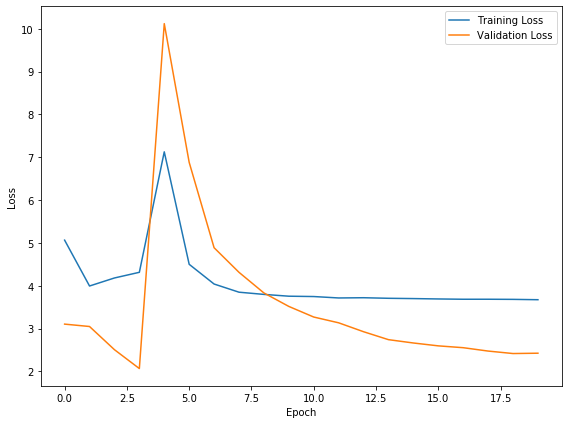

In [23]:

def plot_loss_history(history, n_epochs):
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.plot(list(range(n_epochs)), history.history['loss'], label='Training Loss')
    ax.plot(list(range(n_epochs)), history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    fig.tight_layout()

plot_loss_history(history, 20)

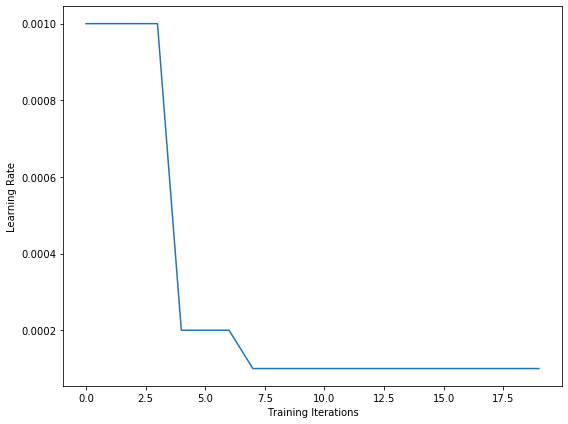

In [24]:
def plot_learning_rate(history):
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.set_xlabel('Training Iterations')
    ax.set_ylabel('Learning Rate')
    ax.plot(history.history['lr'])
    fig.tight_layout()

plot_learning_rate(history)

In [59]:
X_array

[date
 2004-01-01 00:00:00    3
 2004-01-01 01:00:00    3
 2004-01-01 02:00:00    3
 2004-01-01 03:00:00    3
 2004-01-01 04:00:00    3
 2004-01-01 05:00:00    3
 2004-01-01 06:00:00    3
 2004-01-01 07:00:00    3
 2004-01-01 08:00:00    3
 2004-01-01 09:00:00    3
 2004-01-01 10:00:00    3
 2004-01-01 11:00:00    3
 2004-01-01 12:00:00    3
 2004-01-01 13:00:00    3
 2004-01-01 14:00:00    3
 2004-01-01 15:00:00    3
 2004-01-01 16:00:00    3
 2004-01-01 17:00:00    3
 2004-01-01 18:00:00    3
 2004-01-01 19:00:00    3
 2004-01-01 20:00:00    3
 2004-01-01 21:00:00    3
 2004-01-01 22:00:00    3
 2004-01-01 23:00:00    3
 2004-01-02 00:00:00    4
 2004-01-02 01:00:00    4
 2004-01-02 02:00:00    4
 2004-01-02 03:00:00    4
 2004-01-02 04:00:00    4
 2004-01-02 05:00:00    4
                       ..
 2005-05-14 18:00:00    5
 2005-05-14 19:00:00    5
 2005-05-14 20:00:00    5
 2005-05-14 21:00:00    5
 2005-05-14 22:00:00    5
 2005-05-14 23:00:00    5
 2005-05-15 00:00:00    6
 2005-

In [26]:
model2 = EmbeddingNet(cat_vars, cont_vars, embedding_sizes)
batch_size = 128
n_epochs = 10

history = model2.fit(x=X_array, y=y, batch_size=batch_size, epochs=n_epochs,
                     verbose=1, callbacks=[checkpoint],
                     validation_data=(X_val_array, y_val), shuffle=False)

Train on 12024 samples, validate on 168 samples
Epoch 1/10
12024/12024 [==============================] - 2s 185us/step - loss: 5.1553 - rmspe: 0.3482 - val_loss: 2.8275 - val_rmspe: 0.2182
Epoch 2/10
12024/12024 [==============================] - 1s 93us/step - loss: 3.9323 - rmspe: 0.2849 - val_loss: 2.8884 - val_rmspe: 0.2203
Epoch 3/10
12024/12024 [==============================] - 1s 98us/step - loss: 4.0687 - rmspe: 0.2938 - val_loss: 2.6617 - val_rmspe: 0.2110
Epoch 4/10
12024/12024 [==============================] - 1s 107us/step - loss: 4.1558 - rmspe: 0.3037 - val_loss: 2.2378 - val_rmspe: 0.2168
Epoch 5/10
12024/12024 [==============================] - 1s 113us/step - loss: 4.8906 - rmspe: 0.3444 - val_loss: 2.8556 - val_rmspe: 0.3349
Epoch 6/10
12024/12024 [==============================] - 1s 114us/step - loss: 5.6150 - rmspe: 0.3719 - val_loss: 4.3877 - val_rmspe: 0.4656
Epoch 7/10
12024/12024 [==============================] - 1s 103us/step - loss: 5.9991 - rmspe: 0.3867

In [39]:
test_orig = pd.read_csv('area1_ponderada.csv',header=None)
test_orig.columns = ['date','value']


In [41]:
test_orig['date'] = pd.to_datetime(test_orig['date'])
test_orig['day_of_week'] = test_orig['date'].dt.dayofweek
test_orig['month'] = test_orig['date'].dt.month
test_orig['sin_weekday'] = np.sin(2*np.pi*test_orig['date'].dt.dayofweek/7)
test_orig['cos_weekday'] = np.cos(2*np.pi*test_orig['date'].dt.dayofweek/7)
test_orig['sin_month'] = np.sin(2*np.pi*test_orig['date'].dt.month/12)
test_orig['cos_month'] = np.cos(2*np.pi*test_orig['date'].dt.month/12)
test_orig = test_orig.set_index(['date'])
test_orig = test_orig.sort_index()

In [43]:
cat_vars = ['day_of_week','month']
cont_vars = ['sin_weekday','cos_weekday','sin_month','cos_month']
encoders = {}
for v in cat_vars:
    le = LabelEncoder()
    le.fit(test_orig[v].values)
    encoders[v] = le
    test_orig.loc[:, v] = le.transform(test_orig[v].values)
    print('{0}: {1}'.format(v, le.classes_))

day_of_week: [0 1 2 3 4 5 6]
month: [5]


In [45]:
test_orig = test_orig.drop('value', axis=1)

In [49]:
cont_vars

['sin_weekday', 'cos_weekday', 'sin_month', 'cos_month']

In [50]:
test_orig[cont_vars]=scaler.transform(test_orig[cont_vars].values)

In [51]:
for v in cat_vars:
    test_orig[v] = test_orig[v].astype('int').astype('category').cat.as_ordered()
    for v in cont_vars:
        test_orig[v] = test_orig[v].astype('float32')
        

In [65]:
model2.predict(X_test)

ValueError: Error when checking input: expected input_12 to have shape (4,) but got array with shape (166,)

In [64]:
X_test = []

for i, v in enumerate(cat_vars):
    X_test.append(test_orig.iloc[:, i])

X_test.append(pd.DataFrame(X_test).iloc[:, len(cat_vars):])


In [66]:
X_test[0]

date
2005-05-23 00:00:00    0
2005-05-23 01:00:00    0
2005-05-23 02:00:00    0
2005-05-23 03:00:00    0
2005-05-23 04:00:00    0
2005-05-23 05:00:00    0
2005-05-23 06:00:00    0
2005-05-23 07:00:00    0
2005-05-23 08:00:00    0
2005-05-23 09:00:00    0
2005-05-23 10:00:00    0
2005-05-23 11:00:00    0
2005-05-23 12:00:00    0
2005-05-23 13:00:00    0
2005-05-23 14:00:00    0
2005-05-23 15:00:00    0
2005-05-23 16:00:00    0
2005-05-23 17:00:00    0
2005-05-23 18:00:00    0
2005-05-23 19:00:00    0
2005-05-23 20:00:00    0
2005-05-23 21:00:00    0
2005-05-23 22:00:00    0
2005-05-23 23:00:00    0
2005-05-24 00:00:00    1
2005-05-24 01:00:00    1
2005-05-24 02:00:00    1
2005-05-24 03:00:00    1
2005-05-24 04:00:00    1
2005-05-24 05:00:00    1
                      ..
2005-05-28 18:00:00    5
2005-05-28 19:00:00    5
2005-05-28 20:00:00    5
2005-05-28 21:00:00    5
2005-05-28 22:00:00    5
2005-05-28 23:00:00    5
2005-05-29 00:00:00    6
2005-05-29 01:00:00    6
2005-05-29 02:00:00 